<a href="https://colab.research.google.com/github/ak2449/Bayesian-Inference/blob/main/Pulse_Radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import functional as SF
import matplotlib.pyplot as plt
from snntorch import surrogate
import math, time
import torch, torch.nn as nn, torch.nn.functional as F

In [ ]:
# --- 1. Data Generation Parameters (PULSED RADAR) ---
c = 3e8
T_pulse = 50e-9         # 50ns pulse width (determines "thickness" of pulse)
T_pri = 5e-6            # 5us Pulse Repetition Interval (max listening time)
fs_pulse = 1e9          # 1 Giga-sample per second (1ns resolution)
t_window = np.arange(0, T_pri, 1/fs_pulse)
n_samples = len(t_window) # Should be 5000 steps
NOISE_STD_DEV = 0.3     # Standard deviation of noise to add

# --- Parameters for automatic range generation ---
MIN_RANGE_METERS = 25.0
CLASS_WIDTH_METERS = 50.0
CLASS_GAP_METERS = 25.0

# --- Data simulation function (MODIFIED FOR PULSED RADAR) ---
def generate_sample(batch_size, num_classes=3):
    """
    Generates a batch of *pulsed* radar signals and corresponding labels.
    Returns a 1D time-domain signal.
    """
    # Create empty tensors to store the data
    # *** MODIFIED: Shape is now (batch_size, num_timesteps, 1) ***
    data_tensor = torch.zeros((batch_size, n_samples, 1))
    label_tensor = torch.zeros((batch_size), dtype=torch.long)

    # Automatically generate ranges
    ranges = []
    current_start = MIN_RANGE_METERS
    for _ in range(num_classes):
        current_end = current_start + CLASS_WIDTH_METERS
        ranges.append((current_start, current_end))
        current_start = current_end + CLASS_GAP_METERS

    for i in range(batch_size):
        label = np.random.randint(0, num_classes)
        class_range = ranges[label]
        target_range = np.random.uniform(class_range[0], class_range[1])

        # --- Simulate the pulse echo signal ---
        # Range is encoded in time-of-flight
        tau = (2 * target_range) / c

        # Model the received pulse envelope as a Gaussian
        # centered at tau, with width related to T_pulse
        pulse_std = T_pulse / 2.0
        pulse_env = np.exp(-((t_window - tau)**2) / (2 * (pulse_std**2)))

        # Store in tensor
        data_tensor[i, :, 0] = torch.tensor(pulse_env, dtype=torch.float)
        label_tensor[i] = torch.tensor(label, dtype=torch.long)

    return data_tensor, label_tensor

In [ ]:
# --- Preprocess: decimate + normalize (MODIFIED) ---
def preprocess_batch(x, decim=20):
    """
    x: [B, T, 1] float (Pulse data)
    returns: [B, T', 1]
    """
    B, T, C = x.shape

    # *** MODIFIED: Add noise *before* decimation ***
    # This simulates noise at the high-speed ADC
    x = x + (torch.randn_like(x, device=x.device) * NOISE_STD_DEV)

    # [B, C, T] for 1D ops (C=1)
    x = x.permute(0, 2, 1)

    # simple average-pool decimation
    x = F.avg_pool1d(x, kernel_size=decim, stride=decim)  # [B, C, T']

    # Re-enabled per-sample, per-channel normalization
    # This scales the pulse and noise floor of the *decimated* signal
    mean = x.mean(dim=2, keepdim=True)
    std = x.std(dim=2, keepdim=True).clamp_min(1e-6)
    x = (x - mean) / std

    # back to [B, T', C]
    x = x.permute(0, 2, 1)
    return x


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-2150543330.py:10: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time ($\mu s$)")


torch.Size([2, 125, 1])
tensor(0)


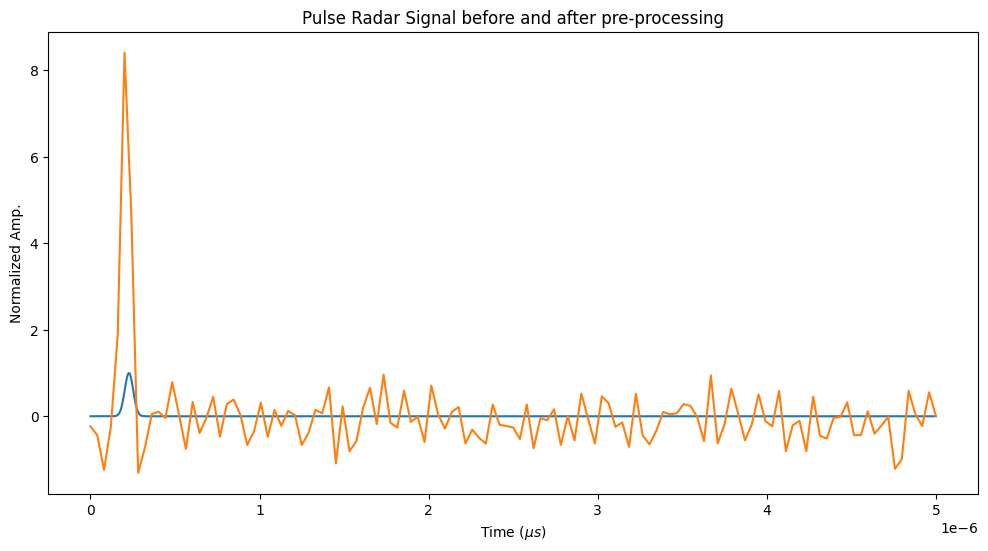

In [ ]:
batch_size = 2
plt.figure(figsize=(12, 6))
data, targets = generate_sample(batch_size)
plt.plot(t_window,data[0])
pre_data = preprocess_batch(data, decim=40)
print(pre_data.shape)
t_processed = np.linspace(0, T_pri, pre_data.shape[1])
plt.plot(t_processed,pre_data[0])
plt.title("Pulse Radar Signal before and after pre-processing")
plt.xlabel("Time ($\mu s$)")
plt.ylabel("Normalized Amp.")
print(targets[0])

Device: cpu
Training for 4 classes (Pulsed Radar)...
Epoch 01 | loss=1.3914 | mean_spike=0.001
Epoch 02 | loss=1.3876 | mean_spike=0.004
Epoch 03 | loss=1.3891 | mean_spike=0.006
Epoch 04 | loss=1.3887 | mean_spike=0.013
Epoch 05 | loss=1.3880 | mean_spike=0.017
Epoch 06 | loss=1.3873 | mean_spike=0.003
Epoch 07 | loss=1.3876 | mean_spike=0.007
Epoch 08 | loss=1.3879 | mean_spike=0.022
Epoch 09 | loss=1.3881 | mean_spike=0.012
Epoch 10 | loss=1.3881 | mean_spike=0.013
Epoch 11 | loss=1.3881 | mean_spike=0.015
Epoch 12 | loss=1.3885 | mean_spike=0.014
Epoch 13 | loss=1.3855 | mean_spike=0.034
Epoch 14 | loss=1.3850 | mean_spike=0.027
Epoch 15 | loss=1.3852 | mean_spike=0.020
Epoch 16 | loss=1.3838 | mean_spike=0.020
Epoch 17 | loss=1.3825 | mean_spike=0.039
Epoch 18 | loss=1.3829 | mean_spike=0.023
Epoch 19 | loss=1.3818 | mean_spike=0.047
Epoch 20 | loss=1.3817 | mean_spike=0.061
Epoch 21 | loss=1.3810 | mean_spike=0.047
Epoch 22 | loss=1.3801 | mean_spike=0.047
Epoch 23 | loss=1.3764 

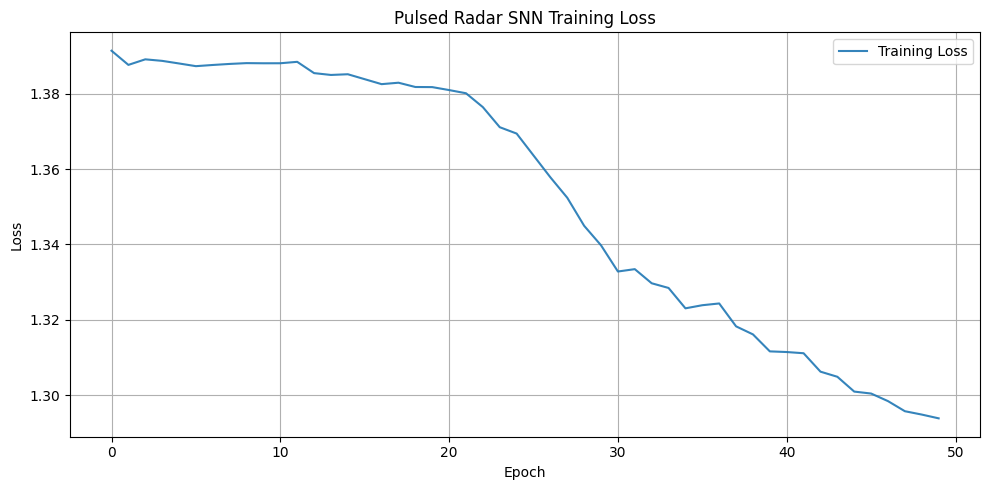

In [ ]:
#Use gpu if possible otherwise CPU is used
device = "cuda" if torch.cuda.is_available() else "cpu"

# *** MODIFIED: Decimation factor D=20 ***
# n_samples (5000) / 20 = 250 time steps. This is a good length.
D = 40
NUM_CLASSES = 4 # Define number of classes

# --- SNN model (time-major loop) (MODIFIED) ---
class RadarSNN(nn.Module): # Renamed
    # *** MODIFIED: in_dim=1 (not 2) ***
    def __init__(self, in_dim=1, hidden=10, num_outputs=2, beta=0.95, threshold=0.75):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden)
        self.lif1 = snn.Leaky(beta=beta, threshold=threshold,spike_grad=surrogate.fast_sigmoid())
        self.fc2 = nn.Linear(hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, threshold=threshold,spike_grad=surrogate.fast_sigmoid())

        # Good inits
        nn.init.kaiming_normal_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        """
        x: [B, T', C] (e.g., [B, 250, 1])
        returns spk_out: [T', B, num_outputs]
        """
        B, T, C = x.shape
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk_rec = []
        for t in range(T):
            h1 = self.fc1(x[:, t, :]) # Input is now [B, 1]
            s1, mem1 = self.lif1(h1, mem1)
            h2 = self.fc2(s1)
            s2, mem2 = self.lif2(h2, mem2)
            spk_rec.append(s2)
        return torch.stack(spk_rec, dim=0)

# --- Training setup ---
# *** MODIFIED: Pass in_dim=1 ***
net = RadarSNN(in_dim=1, hidden=64, num_outputs=NUM_CLASSES).to(device)
opt = torch.optim.Adam(net.parameters(), lr=2e-3)
loss_fn = SF.ce_rate_loss()
grad_clip = 1.0

num_epochs = 50
batches_per_epoch = 64
batch_size = 64

print(f"Device: {device}")
print(f"Training for {NUM_CLASSES} classes (Pulsed Radar)...")

loss_hist = []
for epoch in range(1, num_epochs + 1):
    net.train()
    running = 0.0

    for _ in range(batches_per_epoch):
        # 1) synth batch (now 1D pulse)
        data, targets = generate_sample(batch_size, num_classes=NUM_CLASSES)
        data = data.to(device)           # [B, T, 1]
        targets = targets.to(device)
        # 2) preprocess
        data = preprocess_batch(data, decim=D) # [B, T', 1]
        # 3) forward
        spk_rec = net(data)              # [T', B, NUM_CLASSES]
        # 4) loss
        loss = loss_fn(spk_rec, targets)
        running += loss.item()
        # 5) step
        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(), grad_clip)
        opt.step()

    avg = running / batches_per_epoch
    loss_hist.append(avg)

    with torch.no_grad():
        spk_mean = spk_rec.float().mean().item()
    print(f"Epoch {epoch:02d} | loss={avg:.4f} | mean_spike={spk_mean:.3f}")

print("Training complete.")

# --- Eval ---
net.eval()
with torch.no_grad():
    # Generate a larger test set
    test_data, test_targets = generate_sample(1024, num_classes=NUM_CLASSES)
    test_data = test_data.to(device)
    test_targets = test_targets.to(device)

    # Preprocess (1D Pulse)
    test_data = preprocess_batch(test_data, decim=D)

    spk = net(test_data)                 # [T', B, NUM_CLASSES]
    rates = spk.sum(dim=0)               # [B, NUM_CLASSES]
    pred = rates.argmax(dim=1)           # [B]
    acc = (pred == test_targets).float().mean().item()

print(f"Test accuracy: {acc*100:.2f}%")

print("\nGenerating loss plot...")
fig = plt.figure(figsize=(10, 5))

# Plot training loss
plt.plot(loss_hist, label="Training Loss", alpha=0.9)
plt.title("Pulsed Radar SNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
